In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
!pip install statsmodels

In [3]:
!pip install mplfinance

     |████████████████████████████████| 64 kB 1.8 MB/s 


In [4]:
from datetime import datetime
import numpy as np
import warnings

from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot

import pandas as pd
import matplotlib.pyplot as plt
import math
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# Load data
path = '/content/drive/MyDrive/Intro_DS_2021/Preprocessing Data/SAVA_preprocessed.csv'
df = pd.read_csv(path)
df["Date"] = pd.to_datetime(df["Date"])
df["Date"] = df["Date"].dt.strftime("%m/%d/%y")

df = df.set_index('Date')
close=df[['Close']]
close.head(10)

,Close
Date,
11/24/21,58.05
11/23/21,52.57
11/22/21,52.77
11/19/21,53.19
11/18/21,48.44
11/17/21,47.07
11/16/21,61.69
11/15/21,60.51
11/12/21,68.80


**ARIMA MODEL**

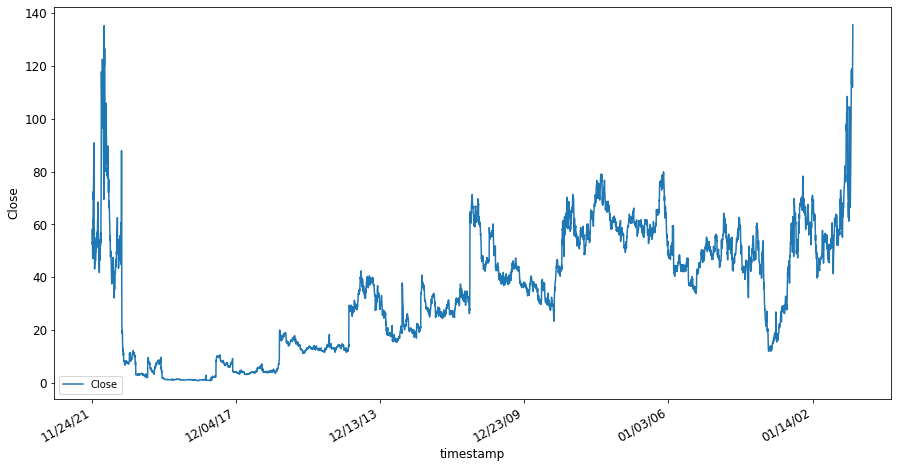

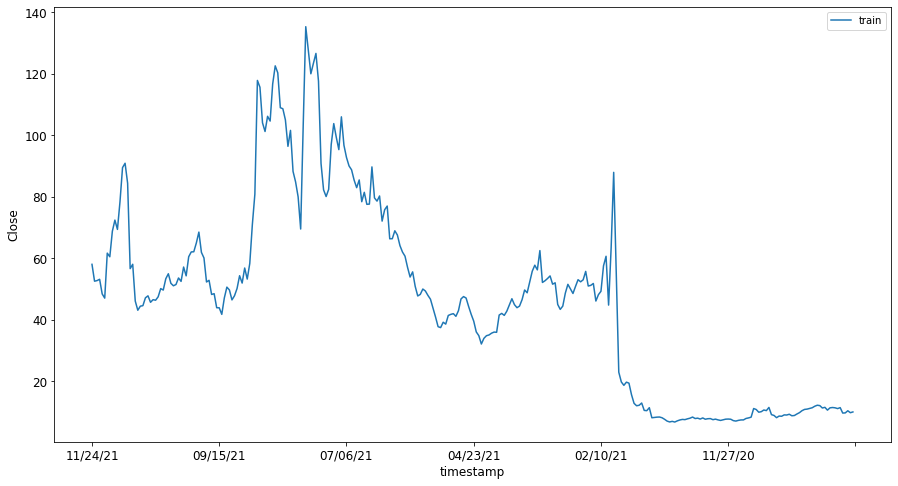

In [6]:
close.plot(y='Close', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.show()

# Load 300 data
close[:300][['Close']].rename(columns={'Close':'train'}) \
    .plot(y=['train'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.show()

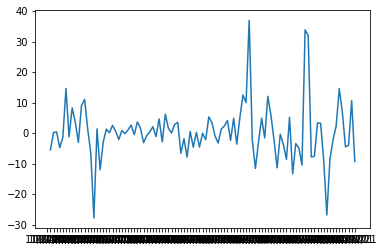

In [7]:
plt.plot(close[:100].diff())

** Create training and testing data sets **

Training data shape:  (3696, 1)
Test data shape:  (1585, 1)


<function matplotlib.pyplot.show>

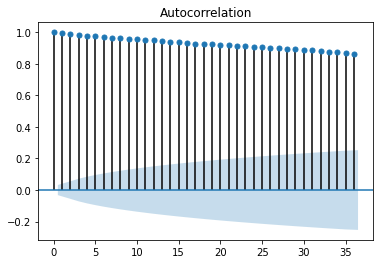

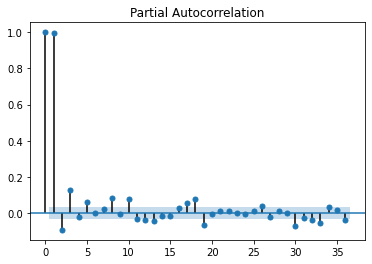

In [8]:
n = int(len(df) * 0.7)
m = int(len(df) * 0.7)

df_train = close.copy()[:n][['Close']]
df_test = close.copy()[m:][['Close']]

print('Training data shape: ', df_train.shape)
print('Test data shape: ', df_test.shape)

plot_acf(df_train['Close'])
plot_pacf(df_train['Close'])
plt.show

** Data prepatation **

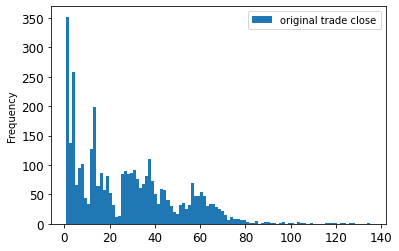

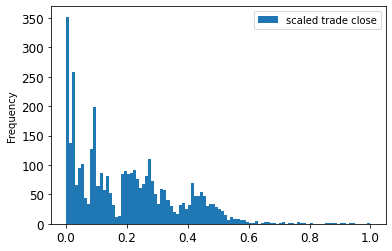

In [9]:
#SCALE TRAIN 
scaler=MinMaxScaler()
df_train['Close']=scaler.fit_transform(df_train)

close[:n][['Close']].rename(columns={'Close':'original trade close'}).plot.hist(bins=100, fontsize=12)
df_train.rename(columns={'Close':'scaled trade close'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [10]:
# SCALE TEST
df_test['Close'] = scaler.transform(df_test)
df_test.head()

,Close
Date,
03/21/07,0.382443
03/20/07,0.373597
03/19/07,0.371516
03/16/07,0.376719
03/15/07,0.378280


** Implemnt ARIMA method **

In [11]:
# Specify the number of steps to forcast ahead
HORIZON=6
print('Forescating horizon:', HORIZON, 'days')

Forescating horizon: 6 days


In [12]:
df_test_shifted = df_test.copy()

for t in range(1, HORIZON):
    df_test_shifted['Close+'+str(t)] = df_test_shifted['Close'].shift(-t)

df_test_shifted=df_test_shifted.dropna(how='any')
df_test_shifted.head(5)

,Close,Close+1,Close+2,Close+3,Close+4,Close+5
Date,,,,,,
03/21/07,0.382443,0.373597,0.371516,0.376719,0.378280,0.361109
03/20/07,0.373597,0.371516,0.376719,0.378280,0.361109,0.368914
03/19/07,0.371516,0.376719,0.378280,0.361109,0.368914,0.373597
03/16/07,0.376719,0.378280,0.361109,0.368914,0.373597,0.374117
03/15/07,0.378280,0.361109,0.368914,0.373597,0.374117,0.375158


In [13]:
order=(1,1,1)
model=ARIMA(df_train,order=order)
results=model.fit()

print(results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3695
Model:                 ARIMA(1, 1, 1)   Log Likelihood                9946.369
Method:                       css-mle   S.D. of innovations              0.016
Date:                Tue, 28 Dec 2021   AIC                         -19884.738
Time:                        09:17:08   BIC                         -19859.879
Sample:                             1   HQIC                        -19875.891
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.392e-05      0.000     -0.047      0.963      -0.001       0.001
ar.L1.D.Close    -0.4729      0.051     -9.289      0.000      -0.573      -0.373
ma.L1.D.Close     0.6182      0.045     

In [14]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(ts_data):
    
    # Q1 **********************Hoàn thành đoạn code sau đây*************
    # Rolling statistics
    roll_mean = ts_data.rolling(30, center=True, closed='both').mean()
    roll_std = ts_data.rolling(5, center=True, closed='both').std()
    #****************************************************************
    
    
    # Plot rolling statistics
    fig = plt.figure(figsize=(20,10))
    plt.subplot(211)
    plt.plot(ts_data, color='black', label='Original Data')
    plt.plot(roll_mean, color='red', label='Rolling Mean(30 days)')
    plt.legend()
    plt.subplot(212)
    plt.plot(roll_std, color='green', label='Rolling Std Dev(5 days)')
    plt.legend()
    
    # Dickey-Fuller test
    print('Dickey-Fuller test results\n')
    df_test = adfuller(ts_data, regresults=False)
    test_result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','# of lags','# of obs'])
    print(test_result)
    for k,v in df_test[4].items():
        print('Critical value at %s: %1.5f' %(k,v))

In [15]:
df.index = pd.to_datetime(df.index, format="%m/%d/%y")
df_final = pd.Series(df['Close'])
type(df_final)

pandas.core.series.Series

Dickey-Fuller test results

Test Statistic      -1.525683
p-value              0.520770
# of lags           33.000000
# of obs          5247.000000
dtype: float64
Critical value at 1%: -3.43160
Critical value at 5%: -2.86209
Critical value at 10%: -2.56706


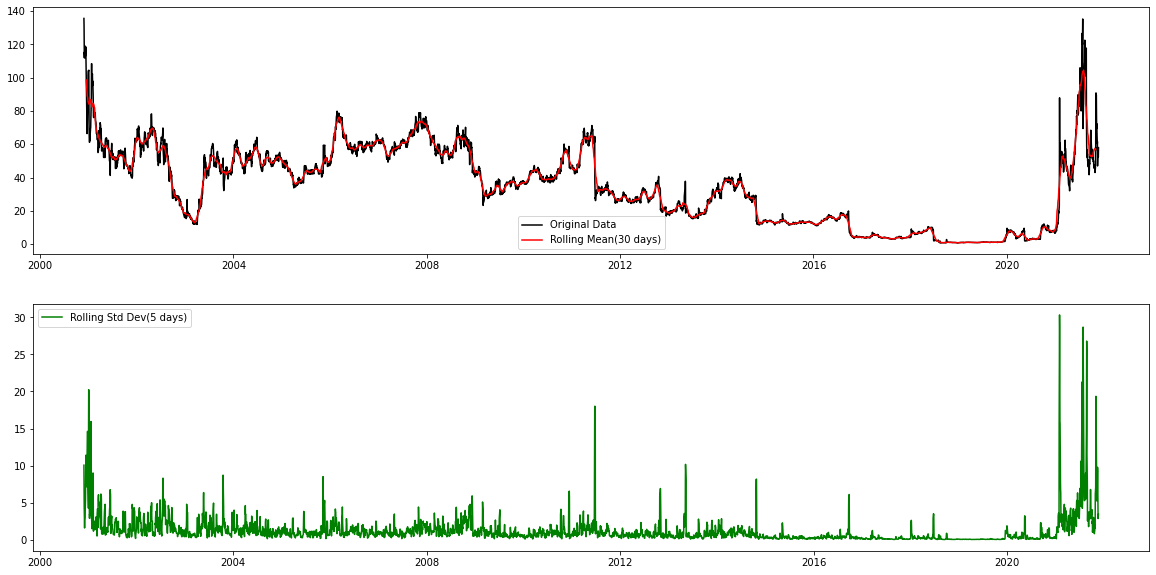

In [16]:
check_stationarity(df_final)

-> Dữ liệu chưa stationary

In [17]:
df_final_diff = df_final - df_final.shift()

Dickey-Fuller test results

Test Statistic   -1.193077e+01
p-value           4.787419e-22
# of lags         3.300000e+01
# of obs          5.246000e+03
dtype: float64
Critical value at 1%: -3.43160
Critical value at 5%: -2.86209
Critical value at 10%: -2.56706


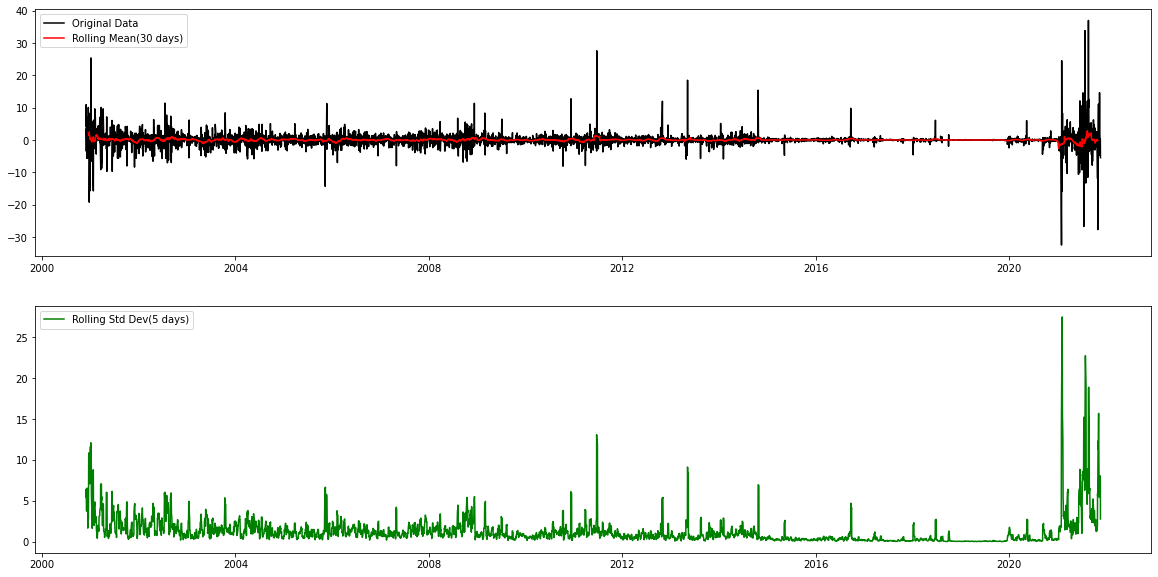

In [18]:
df_final_diff.dropna(inplace=True)
check_stationarity(df_final_diff)

-> Dữ liệu đã stationary

** Evaluate the model **

In [23]:
order = (2, 1, 2)

training_window= 30 # dedicate 30 days for training

train_ts=df_train['Close']
test_ts=df_test_shifted

history=[x for x in train_ts]
history=history[(-training_window):]

predictions=list()

for i in range(test_ts.shape[0]):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.forecast(steps=HORIZON)
    predictions.append(output)
    obs=list(test_ts.iloc[i])
    history.append(obs[0])
    history.pop(0)

ValueError: ignored

In [ ]:
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test_ts, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.031


In [ ]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = df_test.index[0:len(df_test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,9/12/16,t+1,18085.450160,18325.07031
1,9/13/16,t+1,18233.487478,18066.75000
2,9/14/16,t+1,18285.197045,18034.76953
3,9/15/16,t+1,18028.113227,18212.48047
4,9/16/16,t+1,18132.328241,18123.80078


<ipython-input-21-3bfb2b347fe3>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)
No handles with labels found to put in legend.


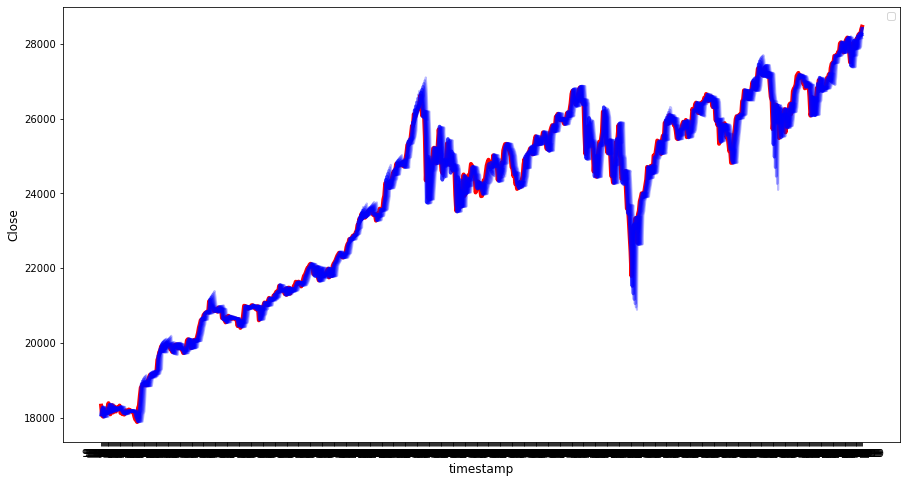

In [ ]:
if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
    for t in range(1, HORIZON+1):
        plot_df['t+'+str(t)] = eval_df[(eval_df.h=='t+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
    ax = fig.add_subplot(111)
    for t in range(1, HORIZON+1):
        x = plot_df['timestamp'][(t-1):]
        y = plot_df['t+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4*math.pow(.9,t), alpha=math.pow(0.8,t))
    
    ax.legend(loc='best')
    
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.show()